# Spectrogram Test Notebook

This notebook demonstrates the varies functionalities available within the **spchutils.spectrogram** module

- plotting of waveforms , spectrograms and segmentations
- computation of basic and mel spectrograms (wrappers around libosa)

Date: 07/05/2021   
Last Modification: 21/05/2021

## First do all the imports


In [ ]:
# You may need to install following packages
# !pip install git+https://github.com/compi1234/spchutils.git
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [1]:
%matplotlib inline
import os,sys,io 
import scipy.signal

from urllib.request import urlopen
from IPython.display import display, Audio, HTML, clear_output
from ipywidgets import interact

import math,time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import librosa as librosa
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
try:
  import soundfile as sf
except:
  ! pip -q install soundfile
  import soundfile as sf
    
import spchutils.spectrogram as specg
import spchutils.audio as audio
import spchutils.utils as spch

## 1. Read in audio data and compute spectrograms

In [2]:
# read a datafile
dir='https://raw.githubusercontent.com/compi1234/spchlab/master/data/'
file = "timit/si1027" #@param {type:"string"}
wavfile = file+".wav" 
wavdata, sr = audio.load(dir+wavfile)

# compute a standard spectrogram and a 80 and 24 channel mel filterbank
spg1 = specg.spectrogram(wavdata,sample_rate=sr,n_mels=None)
spg80 = specg.spectrogram(wavdata,sample_rate=sr,n_mels=80)
spg24 = specg.spectrogram(wavdata,sample_rate=sr,n_mels=24)

#### (a) Basic Plot
x-axis is displayed on index basis

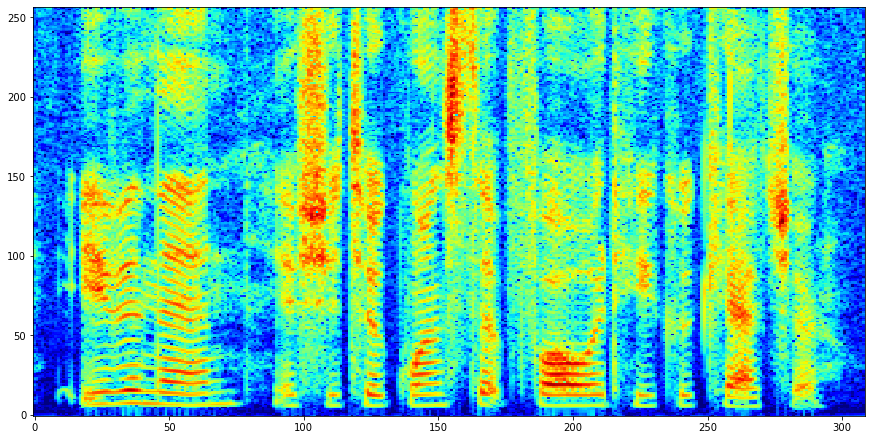

In [3]:
fig,ax = spch.plot_spg(spg1);

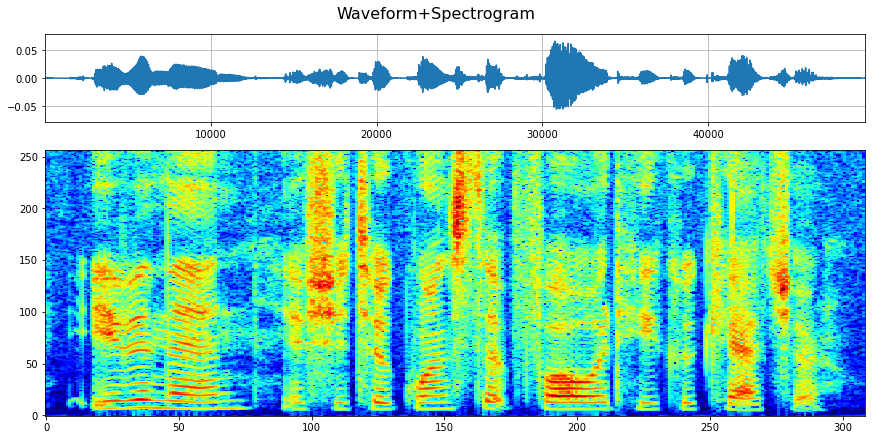

In [4]:
spch.plot_spg(spg1,wav=wavdata,title="Waveform+Spectrogram");

#### (b) Basic Plot with Physical Units
- adding sample_rate to the arguments, everything will be displayed using time-units on the x-axis
- ylabel is the label for the frequency axis
- y is a vector of real life values for the y-axis

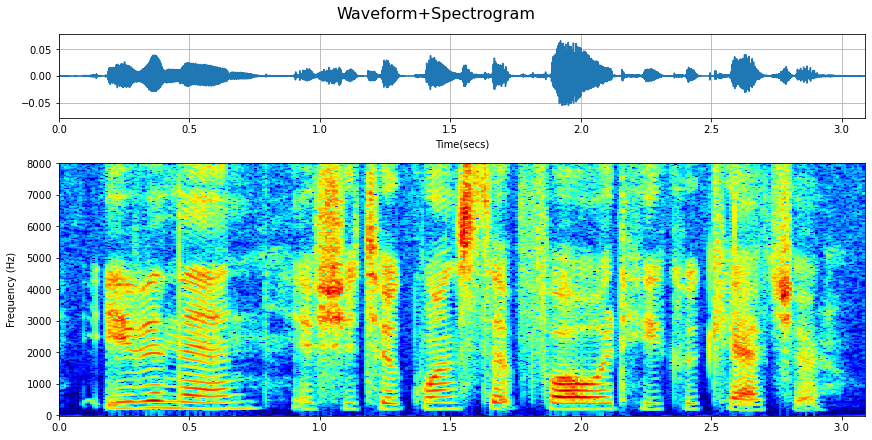

In [5]:
spch.plot_spg(spg1,wav=wavdata,sample_rate=sr,title="Waveform+Spectrogram",ylabel='Frequency (Hz)',y=np.arange(257)*(sr/512));

#### (c) A plot with multiple spectrograms
when adding sample_rate to the arguments, everything will be displayed using time-units on the x-axis

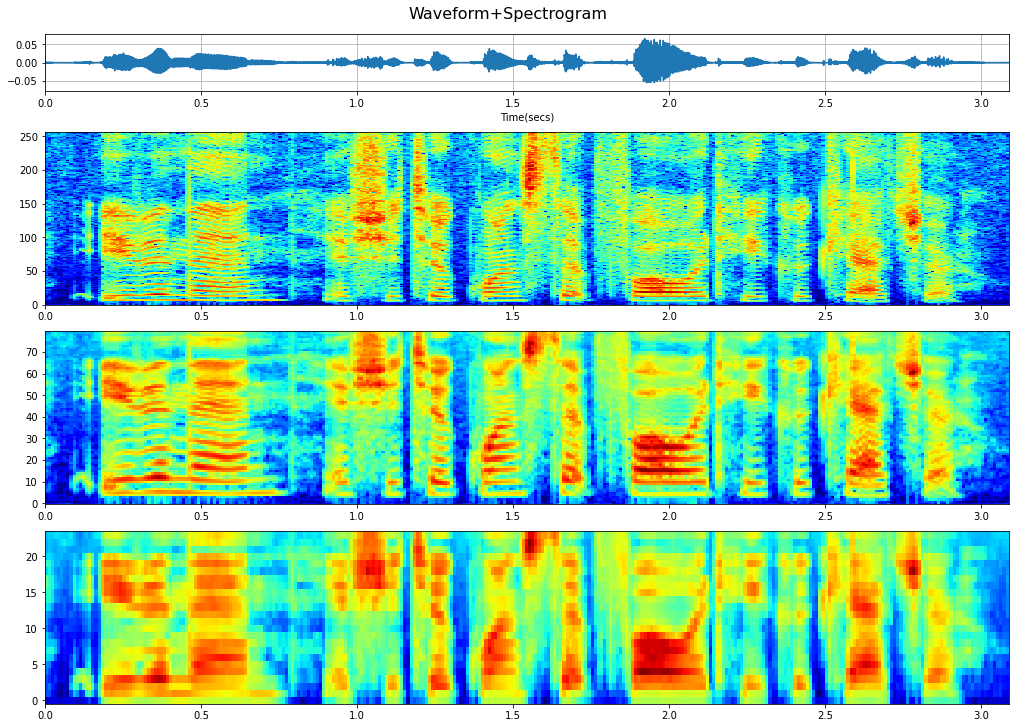

In [6]:
spch.plot_spg([spg1,spg80,spg24],wav=wavdata,sample_rate=sr,title="Waveform+Spectrogram",figsize=(14,10));

## 2. Spectrogram Plots overlayed with Segmenations

In [7]:
# read also some segmentations (for timit files)
sent_segmentation = file+".txt" 
word_segmentation = file+".wrd"
phone_segmentation = file+".phn"
phone_mapping = "timit/phones-61-48-39.txt" #@param {type:"string"}


transcript = io.StringIO(urlopen(dir+sent_segmentation).read().decode('utf-8')).readline().strip().split(None,2)[2]
segwrd = pd.read_csv(dir+word_segmentation,delim_whitespace=True,names=['t0','t1','seg'])
segphn = pd.read_csv(dir+phone_segmentation,delim_whitespace=True,names=['t0','t1','seg'])

# convert sample based segmentations to time based segmentations
segphn['t0']=spch.indx2t(segphn['t0'],1./sr)
segphn['t1']=spch.indx2t(segphn['t1'],1./sr)
segwrd['t0']=spch.indx2t(segwrd['t0'],1./sr)
segwrd['t1']=spch.indx2t(segwrd['t1'],1./sr)

# convert TIMIT61 to TIMIT39
# this routine is not great as it simply maps closures to silence instead to combining
phone_tbl = pd.read_csv(dir+phone_mapping,delim_whitespace=True,names=['T61','T48','T39'])
map61_39 = dict(zip(phone_tbl['T61'],phone_tbl['T39']))
segphn39 = segphn.replace({"seg": map61_39})

#### Spectrograms with added segmentations
- a word segmenation is added to the waveform plot
- a phone segmenation is added to the spectrogram plot

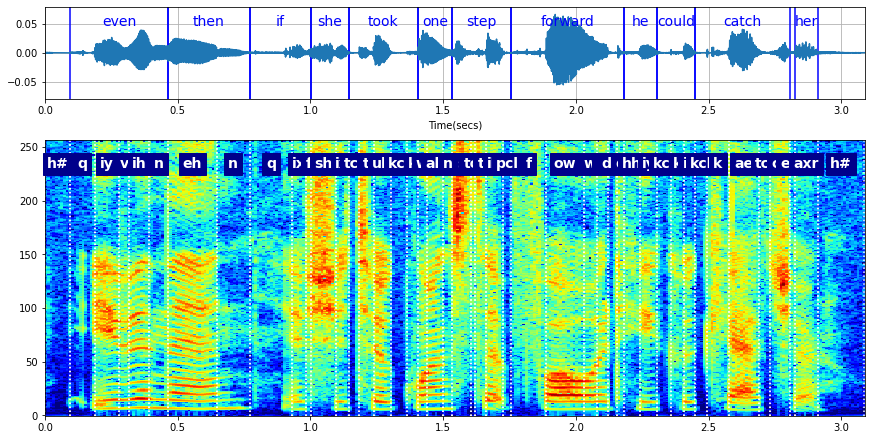

In [8]:
fig,_ = spch.plot_spg(spg1,wav=wavdata,segwav=segwrd,segspg=segphn,sample_rate=sr)
display(Audio(data=wavdata,rate=sr))

#### Zooming in with frame selection
- via the parameter frames[] given first and last frame

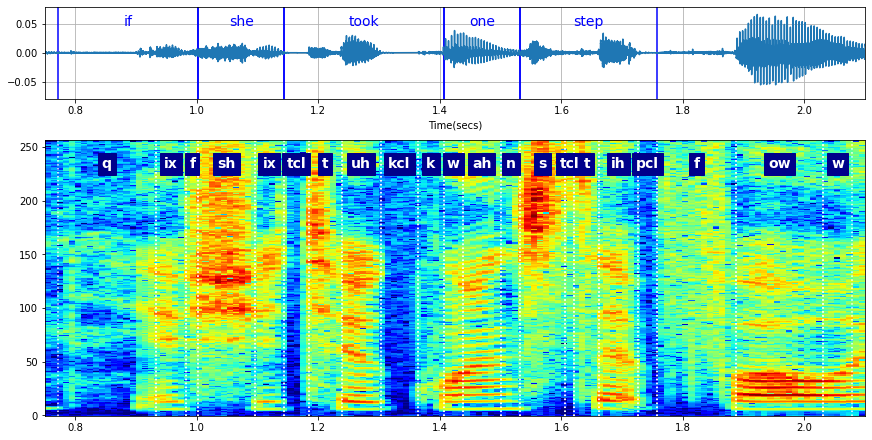

In [9]:
fig,_ = spch.plot_spg(spg1,wav=wavdata,segwav=segwrd,segspg=segphn,frames=[75,210],sample_rate=sr)

## Making your own plots with the low level API
- first create the axis, only specifying the respective height ratios
- then add lines, images or segmentations to the individual axis
- remark: 
    + when placing segmentations in an empty box, then the time limits must be passed via xlim
    + when overlaying segmentations in an existing box, the time axis is inherited, though you may need to specify dx= sampling period

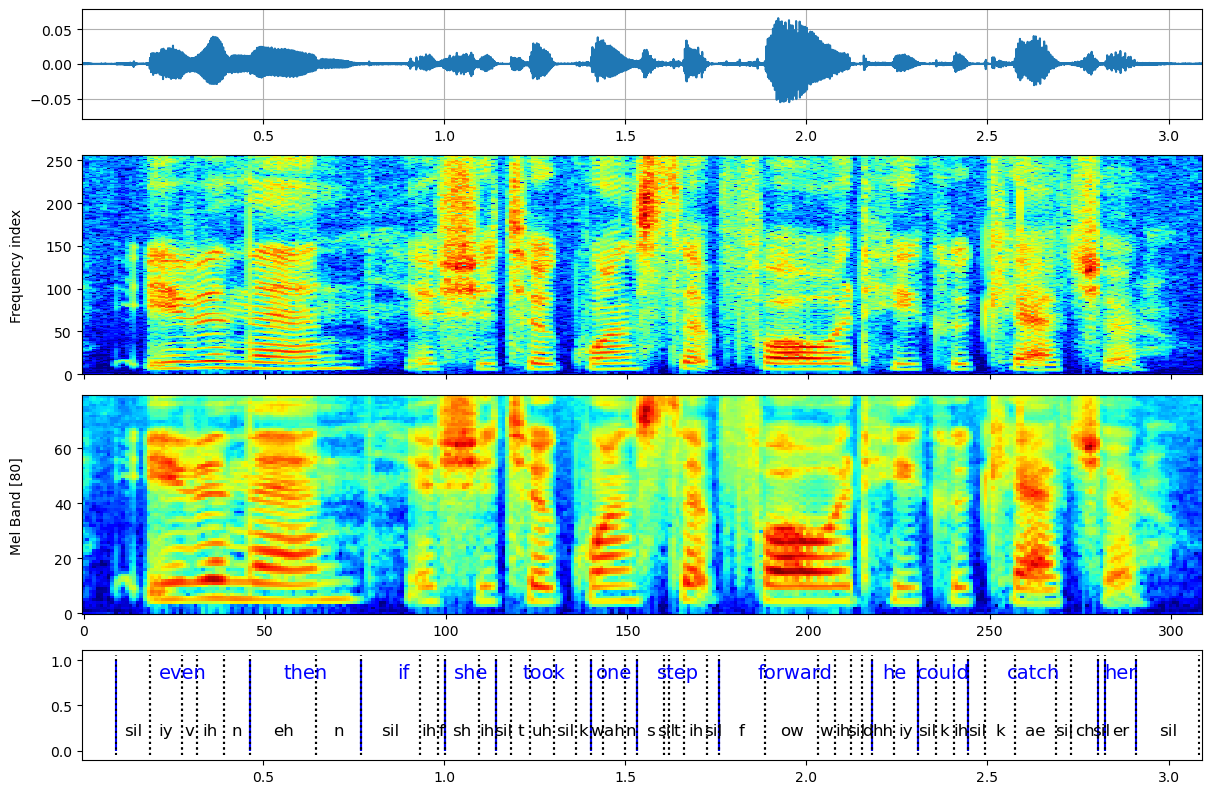

In [10]:
plt.close('all')
def MyPlot(wavdata,sr,spg1,spg2,seg1,seg2,title=None):   
    fig,ax = spch.make_row_grid(figsize=(12,8),height_ratios=[1.,2.,2.,1.],dpi=100)
    spch.add_line_plot(ax[0],wavdata,dx=1./sr)
    spch.add_img_plot(ax[1],spg1,xticks=False)
    spch.add_img_plot(ax[2],spg2)
    spch.add_seg_plot(ax[3],seg1,xlim=ax[0].get_xlim(),ylbl=0.8,
                     lblargs={'color':'blue','fontsize':14},lineargs={'color':'blue'}) 
    spch.add_seg_plot(ax[3],seg2,ylbl=0.2,lineargs={'linestyles':'dotted'})
    fig.suptitle(title,fontsize=16);
    return fig,ax
fig,ax = MyPlot(wavdata,sr,spg1,spg80,segwrd,segphn39)
ax[1].set_ylabel('Frequency index')
ax[2].set_ylabel('Mel Band [80]')
fig.align_ylabels(ax[:])
display(Audio(data=wavdata,rate=sr))

## Spectrogram and waveform plot with optional segmentations

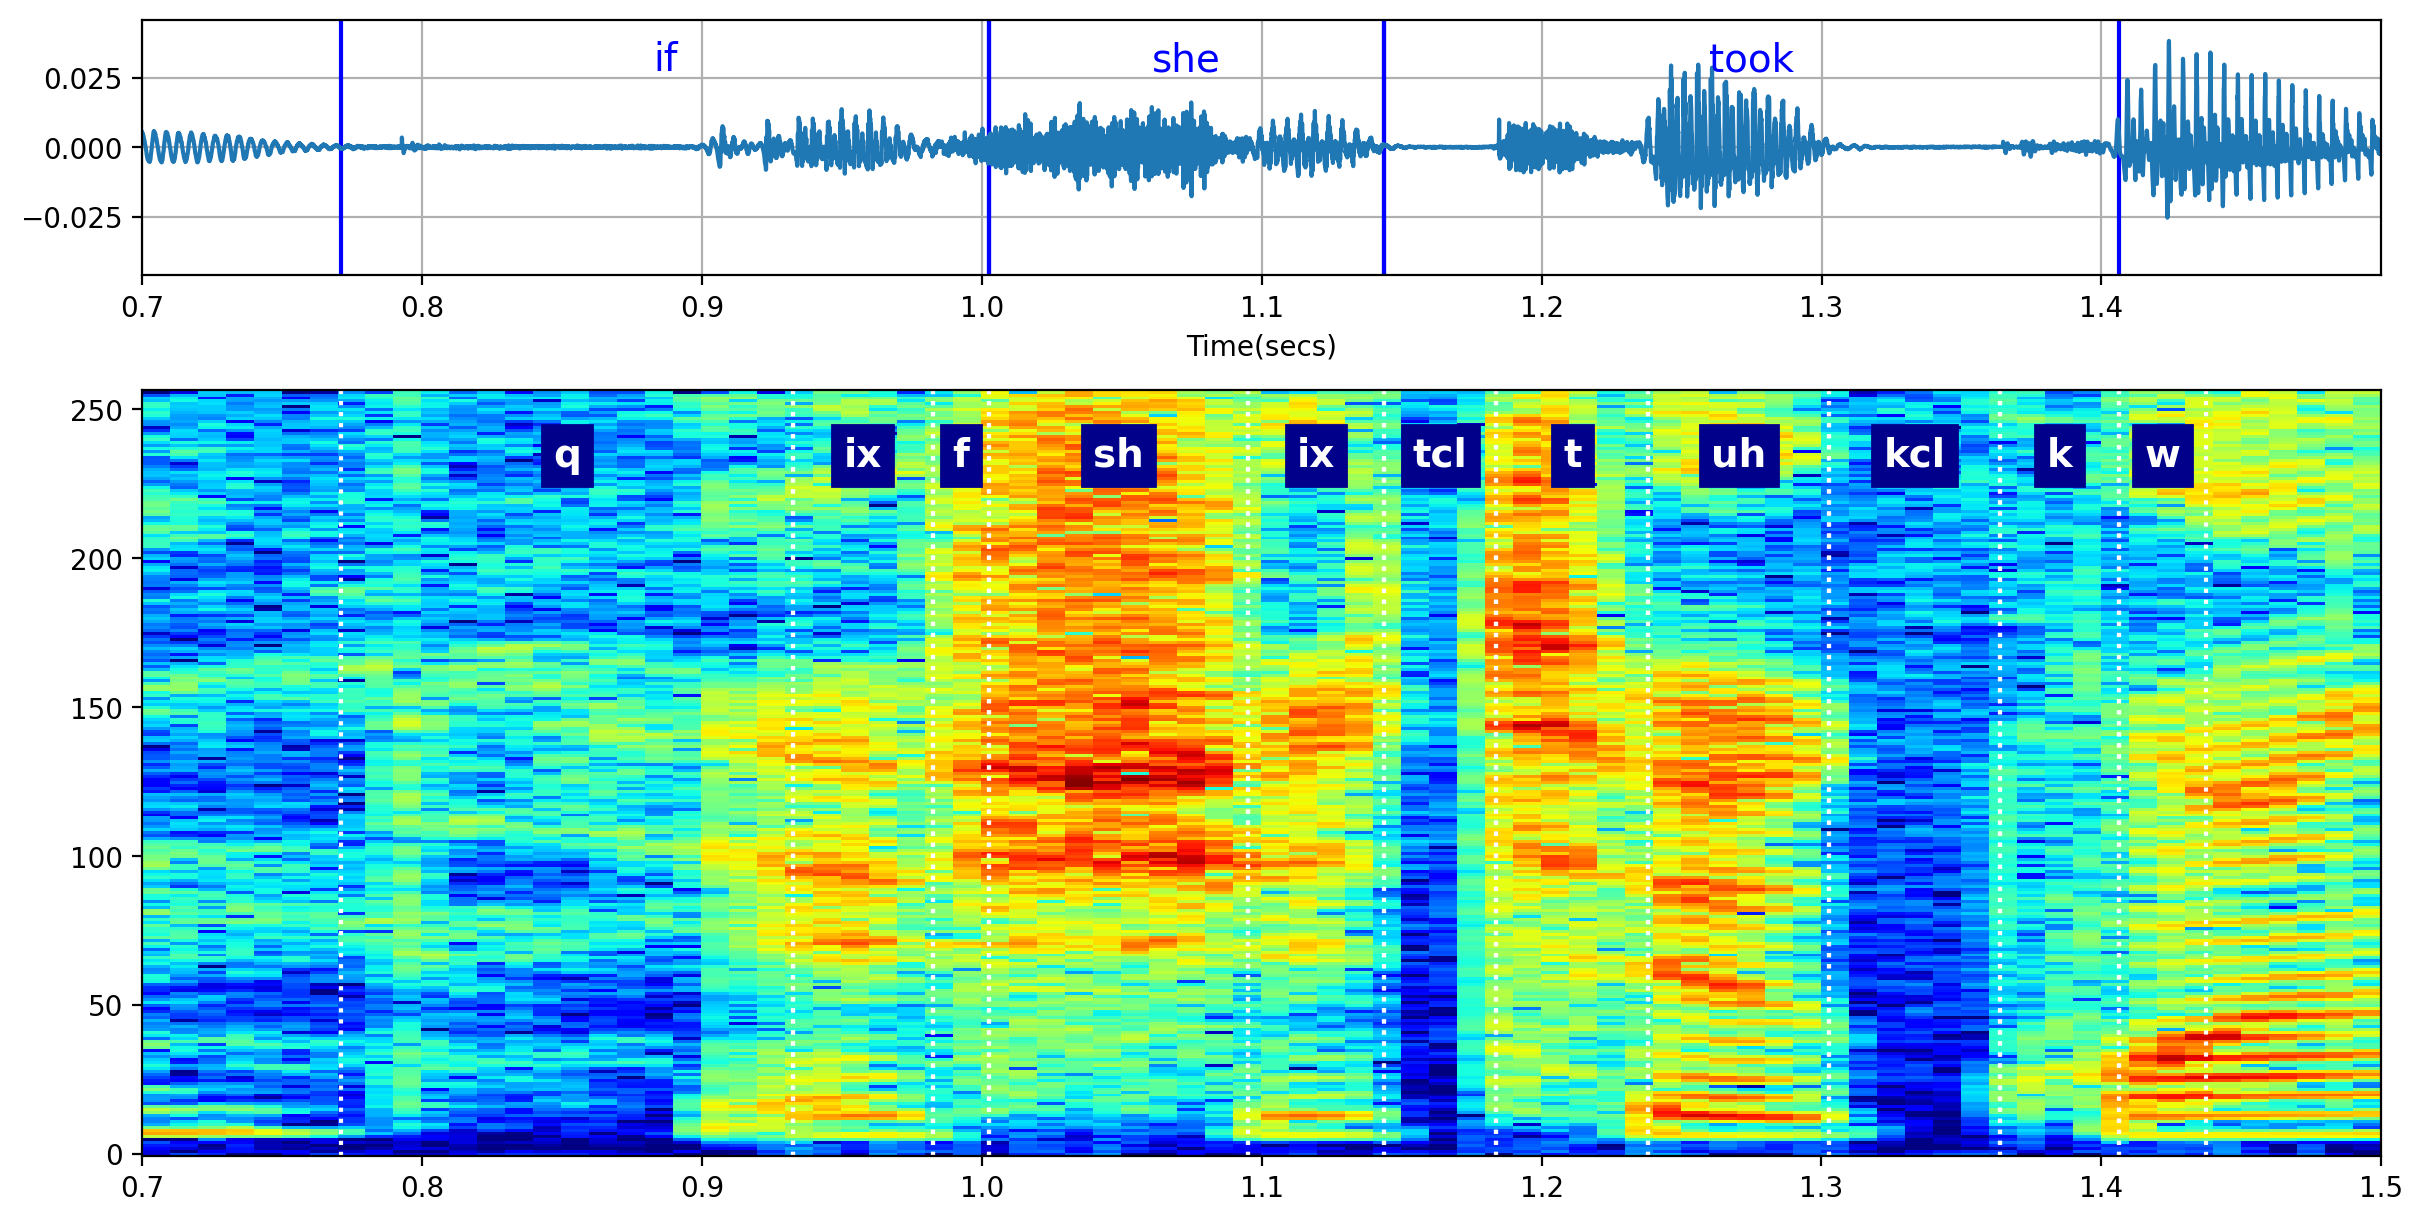

In [11]:
#fig,_ = plot_spg(spg,segspg=segphn39)
fig,_ = spch.plot_spg(spg1,wav=wavdata,segwav=segwrd,segspg=segphn,frames=[70,150],sample_rate=sr,dpi=200)
display(Audio(data=wavdata,rate=sr))

In [12]:
### WORK CELLS
### NOT A MAIN PART OF THIS NOTEBOOK

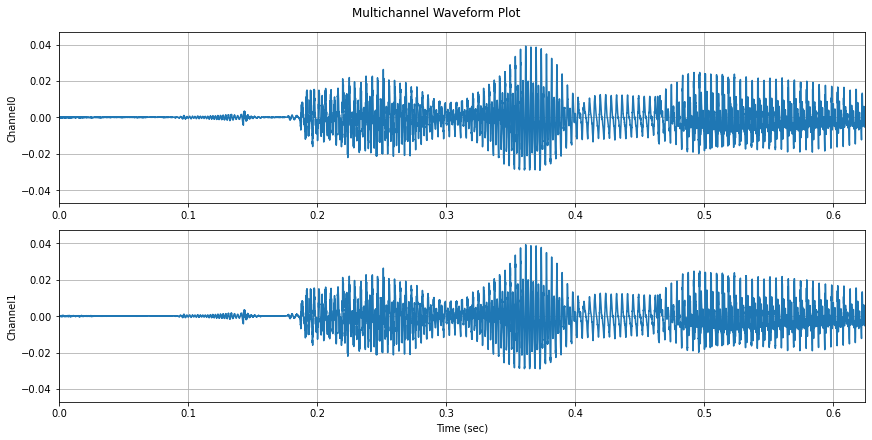

In [13]:
waveform = np.vstack((wavdata,wavdata))
spch.plot_waveform(waveform[:,0:10000],sr,title="Multichannel Waveform Plot");

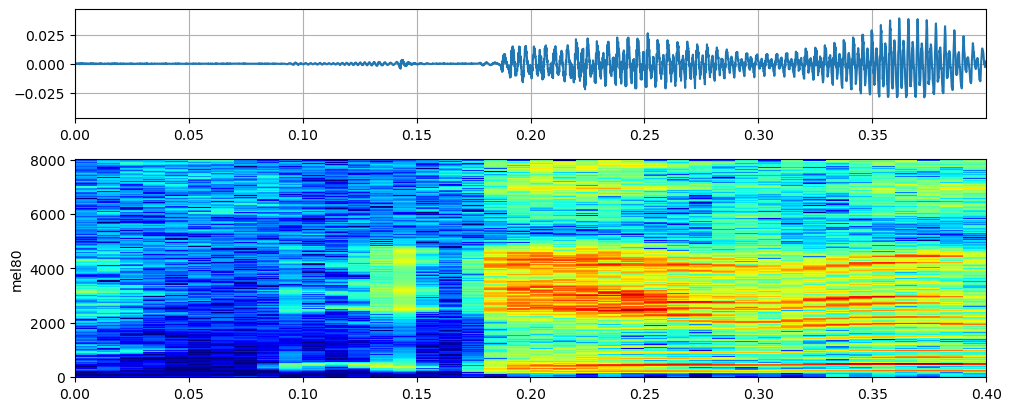

In [14]:
# looking at a small segment to see axis settings in detail
# 1. plot vs. sample and frame numbers - just use defaults
fr0=0
fr1=40
nshift=160
samples = np.arange(fr0*nshift,fr1*nshift)
frames = np.arange(fr0,fr1)
fr2time = spch.indx2t(frames,.01)
freqs = np.arange(257)*(sr/2)/256.
plt.close('all')
wav1 = wavdata[samples]
spg2= spg1[0:,frames]
fig,ax = spch.make_row_grid(figsize=(10,4),height_ratios=[1.,2.],dpi=100)

spch.add_line_plot(ax[0],wav1,x=samples/sr)
spch.add_seg_plot(ax[0],segwrd,ylbl=0.8,xlim=None)
#spch.add_img_plot(ax[1],spg1,x=np.arange(fr0,fr1+1)*.01,ylabel='mel80')
#spch.add_img_plot(ax[1],spg1,x=frames,y=freqs,ylabel='mel80')
spch.add_img_plot(ax[1],spg2,x=fr2time,y=freqs,ylabel='mel80')
spch.add_seg_plot(ax[1],segwrd,dx=None,ylbl=0.9,lblargs={'color':'red','fontsize':14},xlim=None)
#fig.align_ylabels(ax)

## INTERACTIVE FIGURES

#### (a) Reusing the axis for multiple plots in interactive setting

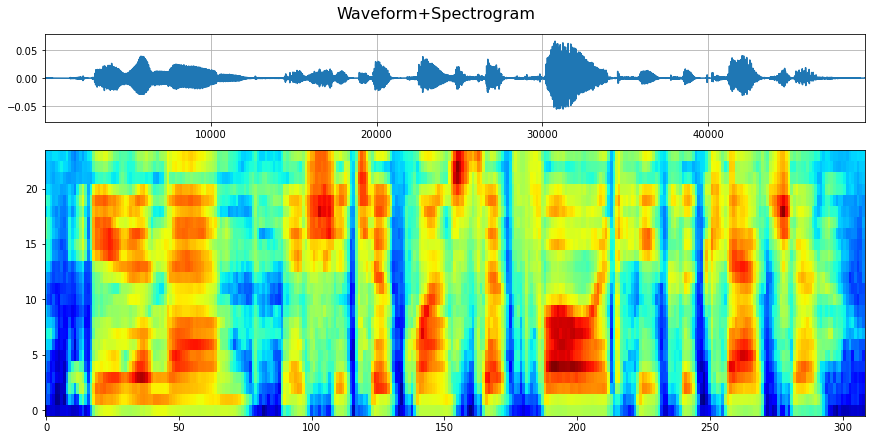

In [16]:
fig,ax = spch.plot_spg(spg1,wav=wavdata,title="Waveform+Spectrogram")
# do a plt.close() to overtake control of the display
plt.close()
display(fig)
time.sleep(1)
spch.plot_spg(spg80,ax=ax,wav=wavdata,title="Waveform+Spectrogram")
clear_output(wait=True)
display(fig);
time.sleep(1)
spch.plot_spg(spg24,ax=ax,wav=wavdata,title="Waveform+Spectrogram")
clear_output(wait=True)
display(fig);

#### (b) Time selection with frame sliders

In [17]:
int_fig,ax = spch.plot_spg(spg1,ax=ax,wav=wavdata,sample_rate=sr)
plt.close()
_,nfr = spg1.shape
@interact(fr1=(0, nfr, 1),fr2=(0, nfr, 1))
def update(fr1 = 0, fr2=nfr): 
    spch.plot_spg(spg1,ax=ax,wav=wavdata,sample_rate=sr,frames=[fr1,fr2])
    clear_output(wait=True)
    display(int_fig)

interactive(children=(IntSlider(value=0, description='fr1', max=309), IntSlider(value=309, description='fr2', …

In [ ]:
# a small utility to merge identical segments in a segmentation
def seg_merge(dfin):
    df = dfin.copy()
    prev = ''
    iiseg = -1
    for iseg in range(0,len(df)):
        t0= df.at[iseg,'t0']
        t1= df.at[iseg,'t1']
        lbl = df.at[iseg,'seg']
        #print(lbl,prev)
        if(lbl != prev):
            iiseg+= 1
            df.at[iiseg,'t0'] = t0
            df.at[iiseg,'seg'] = lbl
        df.at[iiseg,'t1'] = t1
        prev=lbl
    return(df[0:iiseg])

In [ ]:
segnew = seg_merge(segphn39)
segnew[0:5]

In [ ]:
segwrd